In [1]:
##importar paquetes
import pandas as pd
import numpy as np
import datetime as dt
#Para el Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
#para los features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import sklearn as sk 

In [ ]:
 #se llama a las bases de datos desde github
#! git clone https://github.com/KarolLagos/trabajoRH.git

Cloning into 'trabajoRH'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
#bd1 = pd.read_csv('/content/trabajoRH/BasesdeDatosRH/employee_survey_data.csv', sep=";")
#bd2 = pd.read_csv ('/content/trabajoRH/BasesdeDatosRH/general_data.csv', sep=";")
#bd3 = pd.read_csv ('/content/trabajoRH/BasesdeDatosRH/in_time.csv', sep=";")
#bd4 = pd.read_csv ('/content/trabajoRH/BasesdeDatosRH/manager_survey_data.csv', sep=";" )
#bd5 = pd.read_csv ('/content/trabajoRH/BasesdeDatosRH/out_time.csv', sep=";" )
#bd6 = pd.read_csv ('/content/trabajoRH/BasesdeDatosRH/retirement_info.csv', sep=";" )

In [2]:
#importar datos 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# cargar bases
bd1 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/employee_survey_data.csv')
bd2 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/general_data.csv', sep=";")
bd3 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/in_time.csv', sep=";")
bd4 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/manager_survey_data.csv', sep=";" )
bd5 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/out_time.csv', sep=";" )
bd6 = pd.read_csv ('/content/drive/MyDrive/ANALITICA3/retirement_info.csv', sep=";" )

In [ ]:
bd6.head(5)

,EmployeeID,Attrition,retirementDate,retirementType,resignationReason
0,2,Yes,15/10/2016,Resignation,Others
1,7,Yes,20/07/2016,Resignation,Stress
2,14,Yes,08/11/2016,Resignation,Others
3,29,Yes,15/10/2016,Resignation,Others
4,31,Yes,08/02/2016,Resignation,Salary


**#ANÁLISIS BASES**

SE OBSERVARA SUS COLUMNAS PARA SABER CUALES PODRIAN SER UTILES PARA EL ANÁLISIS Y AQUELLAS QUE NO SIRVAN POR SU NÙMERO DE NULOS EN COMPARACIÓN AL NÙMERA DE DATOS TOTAL QUE TENGAN 

In [ ]:
#ANÁLISIS BASES

lista= [bd1, bd2, bd3, bd4, bd5, bd6]

for i in lista:
  print(i.describe())
  print("NULOS:")
  print(i.isnull().sum())
  print('-------------------------------------------------')


In [4]:
#SE TRATA LOS NULOS DE CADA BASE
#NO SE TOMARA LAS BASES 3 Y 5 DEBIDO A LA CANTIDAD DE NULOS EXISTENTES Y QUE LA FECHA DE CUANDO SE RETIRARON ESTÁ EN LABASE DE DATOS RETIRADOS
#Y EN LA GENERAL SE TIENENE LOS AÑOS QUE CADA EMPLEADO TRABAJA EN LA EMPRESA POR LO QUE NO SE VE NECESARIA UTILIZARLAS
#BASE1
nulos = ['EnvironmentSatisfaction',  'JobSatisfaction',  'WorkLifeBalance']
for i in nulos:
  bd1[i] = bd1[i].fillna(bd1[i].median())
#BASE2
bd2['NumCompaniesWorked'] = bd2['NumCompaniesWorked'].fillna(bd2['NumCompaniesWorked'].interpolate())
#BASE6
bd6['resignationReason'] = bd6['resignationReason'].fillna('Others')

In [ ]:
#se unen las bases de datos 1, 2, 4 y 6 las otas no 
from operator import concat
bdt= bd1.merge(bd2, on = 'EmployeeID' , how = 'left')
bdto= bdt.merge(bd4, on = 'EmployeeID' , how = 'left')
bdtotal = bdto.merge(bd6, on = 'EmployeeID' , how = 'left')
bdtotal.head(15)


In [ ]:
bdtotal.shape

(4410, 32)

In [ ]:
#Se analizan los tipos de cada columna
print(bdtotal.shape)
print('-------------------------------------------------')
print(bdtotal.isnull().sum())
print('-------------------------------------------------')
print(bdtotal.dtypes)
print('-------------------------------------------------')

In [ ]:
#Se arregla los tipos de datos de las columnas
bdtotal=bdtotal.convert_dtypes()
bdtotal.dtypes

In [7]:
#SE CAMBIAN A FORMATO FECHA
bdtotal['retirementDate']= pd.to_datetime(bdtotal['retirementDate'])

In [ ]:
bdtotal['retirementDate']
bdtotal.dtypes

In [ ]:
#se crea una nueva columna con meses y otra con días
import numpy as np
import datetime

bdtotal['Day'] = bdtotal['retirementDate'].dt.day 
bdtotal['Month'] = bdtotal['retirementDate'].dt.month 
bdtotal.head(5)

In [10]:
#se arreglan el tipo de dato de las dos nuevas columnas (mes y día)
bdtotal=bdtotal.convert_dtypes()

Debido a que las columnas :Attrition, retirementType, resignationReason, Day y Month tienen nulos porque la base de datos retiros solo tiene 711 registros, al solo tomar en cuenta los empleados que se han retirado y no el nùmero total se decide reemplazar estos nulos por "NO RETIRADOS"

In [ ]:
#Reemplazo de nulos
bdtotal['Attrition'] = bdtotal['Attrition'].fillna('Vigente')
bdtotal['Day'] = bdtotal['Day'].fillna(0)
bdtotal['Month'] = bdtotal['Month'].fillna(0)
bdtotal['retirementType'] = bdtotal['retirementType'].fillna('No aplica')
bdtotal['resignationReason'] = bdtotal['resignationReason'].fillna('No aplica')
bdtotal.head(5)

In [ ]:
#Cambiar el nombre de las columnas a minusculas
bdtotal.columns = bdtotal.columns.str.lower()
bdtotal.columns

In [13]:
#Homologación de categorias 
listaf= ['environmentsatisfaction', 'jobsatisfaction',
        'worklifebalance', 'age', 'businesstravel', 'department',
        'distancefromhome', 'education', 'educationfield', 'employeecount',
        'gender','joblevel', 'jobrole', 'maritalstatus', 'monthlyincome',
        'numcompaniesworked', 'over18', 'percentsalaryhike', 'standardhours',
        'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear',
        'yearsatcompany', 'yearssincelastpromotion', 'yearswithcurrmanager',
        'jobinvolvement', 'performancerating', 'attrition', 'retirementdate',
        'retirementtype', 'resignationreason', 'day', 'month']

In [ ]:
for i in listaf:
  print(bdtotal[i].value_counts())
  print('-----------------------------------------------')

**HOMOLOGACIÓN DE CATEGORIAS**

SE CONCLUYE QUE LAS COLUMNAS AGE, DISTANCEKM, NUMCOMPANIESWORKED, PERCENTSALARY, TOTALWORKINGYEARS, YEARSATCOMPANY, YEARSSINCELASTPROMOTION, YEARSWITHCURRMANAGER y DAY DEBEN SER AGRUPADAS POR INTERVALOS DEBIDO A SU AMPLIA CANTIDAD DE CATEGORIAS.

ADEMÁS SE ELIMINARA EMPLOYEECOUNT, OVER18 Y STANDAR HOURS DEBIDO A QUE SOLO POSEEN UNA CATEGORIA


## **Análisis descriptivo**

In [15]:
#Visualizaciones- PAQUETES
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib.pyplot import figure


In [16]:
bdtot= bdtotal.copy(deep=True)

In [ ]:
#Se visualiza cual es el mes donde existen más retiros con la ayuda de un groupby
d=bdtot.groupby(['month'])[['employeeid']].count().sort_values(by = 'employeeid', ascending = True).head(12).reset_index()
d

In [ ]:
#Grafico de barras 
fig = px.bar(d, x='month', y='employeeid', title= '<b>Meses donde se presenta más despidos<b>')
fig.update_layout(
    template = 'plotly_white',
    title_x = 0.5)
fig.show()

In [ ]:
bdtot.groupby(['day'])[['employeeid']].count().sort_values(by = 'employeeid', ascending = True).reset_index()

In [20]:
#Se realiza rangos para las variables : 'AGE, DISTANCEFROMHOME, NUMCOMPANIESWORKED, PERCENTSALARY, TOTALWORKINGYEARS, YEARSATCOMPANY, YEARSSINCELASTPROMOTION, YEARSWITHCURRMANAGER, DAY
bins = [18, 24, 31, 38, 45, 52, 60]
names = ["18-24", "25-31", "32-38", "39-45", "46-52", "53-60"]
bdtot['age'] = pd.cut(bdtotal['age'], bins, labels = names)

bins = [1, 5, 10, 15, 20, 25, 30]
names = ["1-5", "6-10", "11-15", "16-20", "21-25", "26-30"]
bdtot['distancefromhome'] = pd.cut(bdtotal['distancefromhome'], bins, labels = names)

bins = [0, 2, 5, 8, 11]
names = ["0-2", "3-5", "6-8", "9-11"]
bdtot['numcompaniesworked'] = pd.cut(bdtotal['numcompaniesworked'], bins, labels = names)

bins = [11, 15, 20, 25]
names = ["11-15", "16-20", "21-25"]
bdtot['percentsalaryhike'] = pd.cut(bdtotal['percentsalaryhike'], bins, labels = names)

bins = [0, 10, 20, 30, 40]
names = ["0-10", "11-20", "21-30", "31-40"]
bdtot['totalworkingyears'] = pd.cut(bdtotal['totalworkingyears'], bins, labels = names)

bins = [0, 10, 20, 30, 40]
names = ["0-10", "11-20", "21-30", "31-40"]
bdtot['yearsatcompany'] = pd.cut(bdtotal['yearsatcompany'], bins, labels = names)

bins = [0, 4, 9, 14, 19]
names = ["0-4", "5-9", "10-14", "14-19"]
bdtot['yearssincelastpromotion'] = pd.cut(bdtotal['yearssincelastpromotion'], bins, labels = names)

bins = [0, 4, 9, 14, 19]
names = ["0-4", "5-9", "10-14", "14-19"]
bdtot['yearswithcurrmanager'] = pd.cut(bdtotal['yearswithcurrmanager'], bins, labels = names)

bins = [1, 8, 16, 24, 31]
names = ["1-8", "9-16", "17-24", "25-31"]
bdtot['day'] = pd.cut(bdtotal['day'], bins, labels = names)

In [ ]:
#Análisis descriptivo

lista3= ['environmentsatisfaction', 'jobsatisfaction',
        'worklifebalance', 'age', 'businesstravel', 'department',
        'distancefromhome', 'education', 'educationfield',
        'gender','joblevel', 'jobrole', 'maritalstatus',
        'numcompaniesworked', 'percentsalaryhike',
        'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear',
        'yearsatcompany', 'yearssincelastpromotion', 'yearswithcurrmanager',
        'jobinvolvement', 'performancerating',
        'retirementtype', 'resignationreason', 'day']



for i in lista3:
  x=bdtot.groupby(['attrition', i])[['employeeid']].count().reset_index();
  print(x)
  print('--------------------------------------------------------------------')



In [ ]:
#GRAFICOS
for i in lista3:
  x=bdtot.groupby(['attrition', i])[['employeeid']].count().reset_index();
  fig = px.bar(x, x=i, y="employeeid",
             color='attrition', barmode='group',
             height=400,  title= 'Graph'+ " " + i)
  fig.update_layout(
    title_x = 0.5)
  print(fig.show())
  print('---------------------------------------------------------------------------------------------------------------------------------------------------')

In [23]:
#Eliminar columnas
bdtotal1=bdtotal.drop(['employeecount','over18','standardhours', 'retirementdate'], axis=1)

In [24]:
#Codificación de variable categorica )
from sklearn.preprocessing import OrdinalEncoder
lista1= ['businesstravel', 'department' , 'educationfield','gender', 'jobrole', 'maritalstatus', 'attrition', 'retirementtype', 'resignationreason']
for i in lista1:
  ord = OrdinalEncoder()
  ord.fit([bdtotal1[i]])
  bdtotal1[i]= ord.fit_transform(bdtotal1[[i]])



In [ ]:
#Prueba de la codificación categorica
codifi=['businesstravel', 'department' , 'educationfield', 'jobrole', 'maritalstatus', 'retirementtype', 'resignationreason']
for i in codifi:
  print(bdtotal[i].value_counts())
  print(bdtotal1[i].value_counts())
  print('--------------------------------------')


In [ ]:
#Prueba de la codificación categorica (variable de interes)
print(bdtotal1[['attrition']])
print(bdtotal['attrition'].value_counts())
print(bdtotal[['attrition']])
print(bdtotal1['attrition'].value_counts())

In [ ]:
#boxplot

box_1 = bdtotal1[['environmentsatisfaction', 'jobsatisfaction','worklifebalance','businesstravel', 'department' , 'educationfield', 'jobrole', 'maritalstatus', 'retirementtype', 'resignationreason']]
#Se importa paquete 
import matplotlib.pyplot as plt
figure(figsize=(15, 3), dpi=80);

#Graficos
plt.subplot(1, 7, 1) 
plt.tight_layout()
plt.boxplot(box_1['environmentsatisfaction'])
plt.title('environmentsatisfaction')

plt.subplot(1, 7, 2) 
plt.tight_layout()
plt.boxplot(box_1['jobsatisfaction'])
plt.title('jobsatisfactionl')

plt.subplot(1, 7, 3) 
plt.tight_layout()
plt.boxplot(box_1['worklifebalance'])
plt.title('worklifebalance')

plt.subplot(1, 7, 4) 
plt.tight_layout()
plt.boxplot(box_1['businesstravel'])
plt.title('businesstravel')

plt.subplot(1, 7, 5) 
plt.tight_layout()
plt.boxplot(box_1['department'])
plt.title('department')

plt.subplot(1, 7, 6) 
plt.tight_layout()
plt.boxplot(box_1['educationfield'])
plt.title('educationfield');

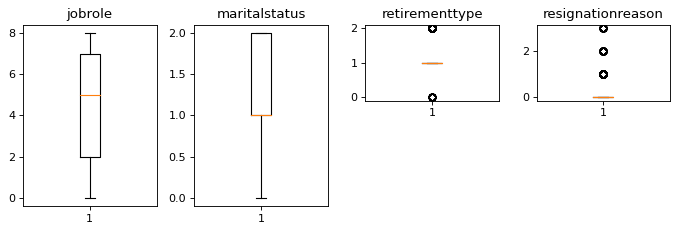

In [ ]:
figure(figsize=(15, 3), dpi=80);

plt.subplot(1, 7, 1) 
plt.tight_layout()
plt.boxplot(box_1['jobrole'])
plt.title('jobrole')

plt.subplot(1, 7, 2) 
plt.tight_layout()
plt.boxplot(box_1['maritalstatus'])
plt.title('maritalstatus')


plt.subplot(2, 7, 3) 
plt.tight_layout()
plt.boxplot(box_1['retirementtype'])
plt.title('retirementtype')

plt.subplot(2, 7, 4) 
plt.tight_layout()
plt.boxplot(box_1['resignationreason'])
plt.title('resignationreason');


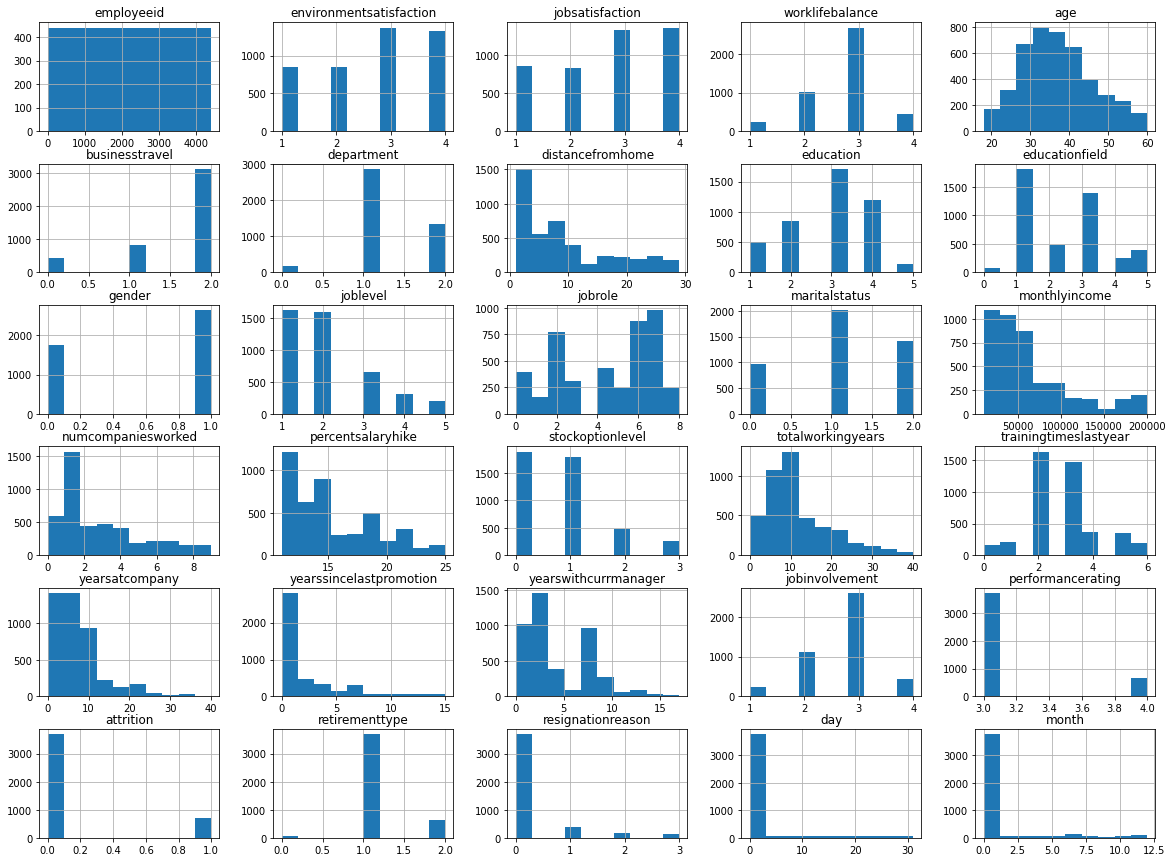

In [28]:
#GRAFICOS DE CORRELACIÓN

bdtotal1.isna().sum()
len(bdtotal1)  ##4340
bdtotal1 = bdtotal1.dropna()
len(bdtotal1)  ##4230
#Visualize the correlation
plt.figure(figsize=(14,14))  #14in by 14in
sns.heatmap(bdtotal1.corr(), annot=True, fmt='.0%')
num_bins = 10
bdtotal1.hist(bins=num_bins, figsize=(20,15))
plt.savefig("hr_histogram_plots")
plt.show()

**SELECCIÓN DE VARIABLES FEATURES Y TARGET**

In [29]:
import sklearn.linear_model as sl
import sklearn.feature_selection as sf
#Recursive feature elimination
modelo= bdtotal1.values
x = bdtotal1.drop(['attrition', 'employeeid'],axis=1).values
y = modelo[:,25]

In [30]:
bdtotal1.dtypes
y=y.astype('int')

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.feature_selection as sf
modelo = LogisticRegression(solver='liblinear')
rfe = sf.RFE(modelo, n_features_to_select=10)
fit = rfe.fit(x,y)

print('Nro. Features: ', fit.n_features_)
print('Features Seleccionados: ', fit.support_)
print('Rankig de features: ', fit.ranking_)

In [32]:
x_main = bdtotal1.drop(['attrition', 'employeeid'],axis=1)
new_col_df = pd.DataFrame({'Columns':x_main.columns, 'Consider':fit.support_})
new_col_df = new_col_df.loc[new_col_df['Consider'] != False]
new_col = new_col_df['Columns'].values
X_reg = x_main.loc[:,new_col]
y_reg = bdtotal1['attrition']

In [ ]:
new_col_df

In [ ]:
baseF = bdtotal1.drop(['attrition', 'employeeid', 'retirementtype', 'resignationreason'], axis=1)
baseF = baseF.head(5)
baseF

**SELECCIÓN DE FEATURES**

Según el Recursive feature elimination se decide dejar los 10 siguientes features:

1.   environmentsatisfaction
2.   jobsatisfaction
3.   worklifebalance
4.   businesstravel
5.   department	
6.   maritalstatus
7.   yearssincelastpromotion
8.   yearswithcurrmanager
9.   jobinvolvement
10.  performancerating




creación de base de datos con los features

In [35]:
bdtotal2=bdtotal1[['environmentsatisfaction','jobsatisfaction','worklifebalance','businesstravel','department','maritalstatus' , 'yearssincelastpromotion', 'yearswithcurrmanager', 'jobinvolvement', 'performancerating', 'attrition']]
arreglo=bdtotal2.values
x = arreglo[:,0:10]
y = arreglo[:,10]
y=y.astype('int')

In [ ]:
bdtotal2.head(5)

**REGRESIÓN LOGISTICA**

In [ ]:
#MODELO
#Separar conjuntos de entrenamiento y pruebas
from sklearn.model_selection import train_test_split
pPruebas = 0.33
semilla = 7
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=pPruebas, random_state=semilla)

#Crear el modelo
modelo = LogisticRegression(solver='liblinear', class_weight={0:1,1:3})

#Entrenar
modelo.fit(x_train, y_train)

#Pruebas
resultado = modelo.score(x_test, y_test)

#Score-puntaje
print("Precisión: ",resultado*100)

In [ ]:
#EVALUACIONES DE DESEMPEÑO
#k-fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Settear el kfold
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

#Crear el modelo
modelo = LogisticRegression(solver='liblinear')

#Entrenamiento y pruebas
resultado = cross_val_score(modelo, x, y, cv=kfold)

#Score-puntaje
print("Precisión: ",resultado.mean()*100, resultado.max()*100, resultado.min()*100)

In [ ]:
#METRICAS DE precisión

#Classification Accuracy

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
modelo = LogisticRegression(solver='liblinear')
score = 'accuracy'
resultado = cross_val_score(modelo,x,y,cv=kfold,scoring=score)
print("Accuracy: ",resultado.mean()*100)

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
test_size = 0.33

seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=seed)
modelo = LogisticRegression(solver='liblinear', class_weight={0:1,1:3})
modelo.fit(x_train, y_train)
predicted = modelo.predict(x_test)
matrix = confusion_matrix(y_test, predicted,labels=[1,0])
print(matrix)

cm = pd.DataFrame(
    confusion_matrix(y_test, predicted,labels=[1,0]), 
    index=['Real:{:}'.format(x) for x in [1,0]], 
    columns=['Pred:{:}'.format(x) for x in [1,0]]
)
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[1][0]
FN = matrix[0][1]

print(cm)
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print()

RANDOM FOREST

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
pPruebas = 0.33
semilla = 7
x = arreglo[:,0:10]
y = arreglo[:,10]
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=pPruebas, random_state=semilla)

#Creamos un forrest para nuestro modelo
clasificador2 = RandomForestClassifier(n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
#Entrenamos nuestro bosque
clasificador2 = clasificador2.fit(x_train, y_train)
#Pruebas
resultado = clasificador2.score(x_test, y_test)

#Score-puntaje
print("Precisión: ",resultado*100)

Precisión:  97.10942876806608


In [44]:
#EVALUACIONES DE DESEMPEÑO
#k-fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Settear el kfold
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

#Crear el modelo
modelo = RandomForestClassifier(n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)

#Entrenamiento y pruebas
resultado = cross_val_score(modelo, x, y, cv=kfold)

#Score-puntaje
print("Precisión: ",resultado.mean()*100, resultado.max()*100, resultado.min()*100)

Precisión:  98.43197278911563 99.31972789115646 97.5


In [45]:
#METRICAS DE PRECISIÓN

#Classification Accuracy

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
modelo = RandomForestClassifier(n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
score = 'accuracy'
resultado = cross_val_score(modelo,x,y,cv=kfold,scoring=score)
print("Accuracy: ",resultado.mean()*100)

Accuracy:  98.43197278911563


In [46]:
#METRICAS DE PRECISIÓN
#Confusion Matrix
test_size = 0.33

seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=seed)
modelo =  RandomForestClassifier(n_estimators = 10,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123)
modelo.fit(x_train, y_train)
predicted = modelo.predict(x_test)
matrix = confusion_matrix(y_test, predicted,labels=[1,0])
print(matrix)

cm = pd.DataFrame(
    confusion_matrix(y_test, predicted,labels=[1,0]), 
    index=['Real:{:}'.format(x) for x in [1,0]], 
    columns=['Pred:{:}'.format(x) for x in [1,0]]
)
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[1][0]
FN = matrix[0][1]

print(cm)
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print()# Print a new line

[[ 204   40]
 [   2 1207]]
        Pred:1  Pred:0
Real:1     204      40
Real:0       2    1207
Model Testing Accuracy = "0.9710942876806608!"



In [ ]:
predicción=pd.DataFrame(modelo.predict(x[:70]))
predicción

In [74]:
bdtotal2.head(70)

,environmentsatisfaction,jobsatisfaction,worklifebalance,businesstravel,department,maritalstatus,yearssincelastpromotion,yearswithcurrmanager,jobinvolvement,performancerating,attrition
0,3,4,2,2.0,2.0,1.0,0,0,3,3,0.0
1,3,2,4,1.0,1.0,2.0,1,4,2,4,1.0
2,2,2,1,1.0,1.0,1.0,0,3,3,3,0.0
3,4,4,3,0.0,1.0,1.0,7,5,2,3,0.0
4,4,1,3,2.0,1.0,2.0,0,4,3,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
66,4,4,3,2.0,1.0,1.0,1,9,3,3,0.0
67,3,3,3,1.0,1.0,1.0,8,9,2,3,0.0
68,3,4,3,1.0,1.0,1.0,13,3,3,3,0.0
69,4,3,2,2.0,1.0,1.0,0,0,3,3,1.0


In [68]:
bdtotal3=bdtotal[['environmentsatisfaction','jobsatisfaction','worklifebalance','businesstravel','department','maritalstatus' , 'yearssincelastpromotion', 'yearswithcurrmanager', 'jobinvolvement', 'performancerating', 'attrition']]
bdtotal3.head(30)

,environmentsatisfaction,jobsatisfaction,worklifebalance,businesstravel,department,maritalstatus,yearssincelastpromotion,yearswithcurrmanager,jobinvolvement,performancerating,attrition
0,3,4,2,Travel_Rarely,Sales,Married,0,0,3,3,Vigente
1,3,2,4,Travel_Frequently,Research & Development,Single,1,4,2,4,Yes
2,2,2,1,Travel_Frequently,Research & Development,Married,0,3,3,3,Vigente
3,4,4,3,Non-Travel,Research & Development,Married,7,5,2,3,Vigente
4,4,1,3,Travel_Rarely,Research & Development,Single,0,4,3,3,Vigente
5,3,2,2,Travel_Rarely,Research & Development,Married,7,7,3,3,Vigente
6,1,3,1,Travel_Rarely,Research & Development,Single,0,0,3,4,Yes
7,1,2,3,Travel_Rarely,Research & Development,Married,0,0,3,4,Vigente
8,2,4,3,Travel_Rarely,Research & Development,Married,7,8,3,4,Vigente
9,2,1,3,Non-Travel,Research & Development,Divorced,1,5,3,3,Vigente


In [ ]:
#Visualización de predicciones
tabla = bdtotal1([],axis=1)

tabla["Predicción"]= Prediccion
tabla

**Modelo Naive Bayes**

In [ ]:
# Metodo Naive Bayes
from sklearn.naive_bayes import GaussianNB
kfold = KFold(n_splits=10, random_state=5, shuffle=True)
modelo = GaussianNB()
resultado = cross_val_score(modelo, x, y, cv=kfold)
resultado.mean()

In [ ]:
#Evaluación del modelo-- evaluación de desempeño
#k-fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Settear el kfold
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

#Crear el modelo
modelo = GaussianNB()

#Entrenamiento y pruebas
resultado = cross_val_score(modelo, x, y, cv=kfold)

#Score-puntaje
print("Precisión: ",resultado.mean()*100, resultado.max()*100, resultado.min()*100)


In [ ]:
#METRICAS DE precisión

#Classification Accuracy

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
modelo = GaussianNB()
score = 'accuracy'
resultado = cross_val_score(modelo,x,y,cv=kfold,scoring=score)
print("Accuracy: ",resultado.mean()*100)

In [ ]:
#METRICAS DE precisión
#Confusion Matrix
test_size = 0.33

seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=seed)
modelo =  GaussianNB()
modelo.fit(x_train, y_train)
predicted = modelo.predict(x_test)
matrix = confusion_matrix(y_test, predicted,labels=[1,0])
print(matrix)

cm = pd.DataFrame(
    confusion_matrix(y_test, predicted,labels=[1,0]), 
    index=['Real:{:}'.format(x) for x in [1,0]], 
    columns=['Pred:{:}'.format(x) for x in [1,0]]
)
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[1][0]
FN = matrix[0][1]

print(cm)
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print()# Print a new line

--> hasta aqui

**ARBOL DE DECISIÓN**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


In [ ]:
# Metodo árbol de decisión

kfold = KFold(n_splits=5, random_state=7, shuffle=True)
modelo = DecisionTreeClassifier()
resultado1 = cross_val_score(modelo, x, y, cv=kfold)
print(resultado1.mean())

In [ ]:
list=('environmentsatisfaction','jobsatisfaction','worklifebalance','businesstravel','department','maritalstatus' , 'yearssincelastpromotion', 'yearswithcurrmanager', 'jobinvolvement', 'performancerating')
features = list
#Se imprime la lista que se creo 
print(features)

In [ ]:
#Se llama a la fucion decisiontreeclassifier y se le da el nombre de cladificador
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from io import StringIO
import pydotplus
from sklearn import tree
import pickle
clasificador = tree.DecisionTreeClassifier()
#Al clasificador se llama fit que se utiliza para cada estimador y se le da el argumento de x y y
clfEntrenado = clasificador.fit(x,y)
#Se llama el metodo de StringIO y se le da el nombre de dot_data
dot_data = StringIO()  
#Se llama a la funcion export_graphviz para poder ver la representacion grafica del arbol de decision
tree.export_graphviz(clfEntrenado, out_file=dot_data, feature_names=features)  
#Se crea graph con la funcion graph_from_dota_data para ver el grafico que tiene un formato DOT
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Se llama la funcion image para que los datos se desplieguen en la image

In [ ]:
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Clasification Report
from sklearn.metrics import classification_report
test_size = 0.33
seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=seed)
model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)
predicted = model.predict(x_test)
reporte = classification_report(y_test, predicted)
print(reporte)



              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1209
           1       0.56      0.04      0.08       244

    accuracy                           0.83      1453
   macro avg       0.70      0.52      0.49      1453
weighted avg       0.79      0.83      0.77      1453



In [ ]:
#Evaluación del modelo-- evaluación de desempeño
#k-fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Settear el kfold
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

#Crear el modelo
modelo = tree.DecisionTreeClassifier()

#Entrenamiento y pruebas
resultado = cross_val_score(modelo, x, y, cv=kfold)

#Score-puntaje
print("Precisión: ",resultado.mean()*100, resultado.max()*100, resultado.min()*100)

Precisión:  98.27277880849309 99.77324263038548 97.04545454545455


In [ ]:
#METRICAS DE precisión

#Classification Accuracy

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
modelo = tree.DecisionTreeClassifier()
score = 'accuracy'
resultado = cross_val_score(modelo,x,y,cv=kfold,scoring=score)
print("Accuracy: ",resultado.mean()*100)

Accuracy:  98.25005153576582


In [ ]:
#METRICAS DE precisión
#Confusion Matrix
test_size = 0.33

seed = 7
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=seed)
modelo =  tree.DecisionTreeClassifier()
modelo.fit(x_train, y_train)
predicted = modelo.predict(x_test)
matrix = confusion_matrix(y_test, predicted,labels=[1,0])
print(matrix)

cm = pd.DataFrame(
    confusion_matrix(y_test, predicted,labels=[1,0]), 
    index=['Real:{:}'.format(x) for x in [1,0]], 
    columns=['Pred:{:}'.format(x) for x in [1,0]]
)
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[1][0]
FN = matrix[0][1]

print(cm)
print('Model Testing Accuracy = "{}!"'.format(  (TP + TN) / (TP + TN + FN + FP)))
print()# Print a new line

[[ 222   22]
 [  15 1194]]
        Pred:1  Pred:0
Real:1     222      22
Real:0      15    1194
Model Testing Accuracy = "0.9745354439091535!"

